## 0. Code Setup and Helper Functions

### 0.1 Import all necessary packages

In [1]:
import os
import zlib
import pickle as pkl
import sklearn
import pandas as pd
from tabulate import tabulate
from top2vec import Top2Vec

2022-06-07 23:59:13.927045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 23:59:13.927069: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 0.2 Path Adjustments

In [2]:
assert os.path.exists('../src'), f"[ERROR] The path src not detected in the parent directory '{os.getcwd()}'."

if os.getcwd().endswith('/notebooks'):
    os.chdir('../src')

print(f'[INFO] Current Directory: "{os.getcwd()}".')

[INFO] Current Directory: "/home/iceking/Desktop/22SS-TUM Lecture Docs/3. Praktikum (IN2106, IN4249)/Repo/topic-modeling-advancements/src".


## 1. Main Part

In [6]:
import time
from collections import OrderedDict
from multiprocessing import cpu_count
from typing import List, Dict, Any, Tuple

import pandas as pd
from top2vec import Top2Vec

from utils import load_documents, create_modeling_params_dict, create_modeling_results_dict


def print_topic_stats(stats: List[Dict[str, Any]]) -> None:
    for stat in stats:
        print(f'[INFO] Topic #{str(stat["topic_num"]).zfill(2)}:')
        print(f'     > From Reduced Model:{stat["reduced"]}.')
        print(f'     > Topic Size:{stat["topic_size"]}.')
        print(f'     > Topic Words:', str(stat['topic_words']).replace('\n', '\n\t\t'))
        print(f'     > Topic Word Scores:', str(stat['word_scores']).replace('\n', '\n\t\t'))


def get_topic_stats(model_t2v: Top2Vec, is_reduced: bool = False) -> List[Dict[str, Any]]:
    num_topics = model_t2v.get_num_topics(reduced=is_reduced)
    topic_sizes, topic_nums = model_t2v.get_topic_sizes(reduced=is_reduced)
    topic_words, word_scores, _ = model_t2v.get_topics(num_topics=num_topics, reduced=is_reduced)

    stats = []
    for tn, ts, tw, ws in zip(topic_nums, topic_sizes, topic_words, word_scores):
        stats.append(OrderedDict([
            ('reduced', is_reduced),
            ('topic_num', tn),
            ('topic_size', ts),
            ('topic_words', tw),
            ('word_scores', ws)
        ]))
    return stats


def print_params(dataset_dir: str, speed: str, embedding_model: str, num_topics: int, data_col: str):
    print('[INFO] Top2Vec Parameters:')
    print(f'    > Input Dataset Directory:"{dataset_dir}".')
    print(f'    > Input Dataset Data Column:"{data_col}".')
    print(f'    > Model Speed:"{speed}".')
    print(f'    > Embedding Model:"{embedding_model}".')
    print(f'    > Pre-specified Number of Topics:{num_topics}.')


In [35]:
dataset_dir= '../data/crisis_resource_toy'
data_col= 'text'
num_topics= 4

# ####### Top2Vec Specific Arguments #########
# embedding_model= 'doc2vec'
embedding_model= 'universal-sentence-encoder'
doc2vec_speed= 'fast-learn'
min_count= 50
umap_args= {'n_neighbors': 15, 'n_components': 5, 'metric': 'cosine'}
hdbscan_args= {'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}

In [36]:
time_start = time.time()

print_params(dataset_dir, doc2vec_speed, embedding_model, num_topics, data_col)
print(f'[INFO] Top2Vec is running for dataset directory:"{dataset_dir}".')

documents = load_documents(dataset_dir, data_col)
model = Top2Vec(
    documents, speed=doc2vec_speed, workers=cpu_count(), min_count=min_count,
    embedding_model=embedding_model, umap_args=umap_args, hdbscan_args=hdbscan_args
)

non_reduced_num_topics = model.get_num_topics(reduced=False)
print(f'[INFO] Original (Non-reduced) Number of Topics: {non_reduced_num_topics}.')
topic_stats = get_topic_stats(model_t2v=model, is_reduced=False)
if num_topics is not None:
    if non_reduced_num_topics > num_topics:
        model.hierarchical_topic_reduction(num_topics=num_topics)
        topic_stats = get_topic_stats(model_t2v=model, is_reduced=True)
    else:
        print('[WARN] # of topics is pre-specified but non_reduced_num_topics <= num_topics, so not reduced!')
        print(f'   > non_reduced_num_topics:{non_reduced_num_topics}, given num_topics:{num_topics}!')
        time.sleep(3)
duration_secs = float('%.3f' % (time.time() - time_start))
print_topic_stats(stats=topic_stats)

print(f'[INFO] Top2Vec successfully terminated for data:"{dataset_dir}".')

params_dict = create_modeling_params_dict(
    timestamp=time_start, method_specific_params={'speed': doc2vec_speed, 'embedding_model': embedding_model},
    dataset_dir=dataset_dir, data_col=data_col, num_topics=num_topics, method='top2vec'
)
results_dict = create_modeling_results_dict(
    num_detected_topics=non_reduced_num_topics, num_final_topics=len(topic_stats), duration_secs=duration_secs
)
params_df = pd.DataFrame([params_dict] * len(topic_stats))
results_df = pd.DataFrame([results_dict] * len(topic_stats))
model_output_df = pd.concat([params_df, pd.DataFrame(topic_stats), results_df], axis=1)

2022-06-09 10:05:34,647 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-06-09 10:05:34,672 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model


[INFO] Top2Vec Parameters:
    > Input Dataset Directory:"../data/crisis_resource_toy".
    > Input Dataset Data Column:"text".
    > Model Speed:"fast-learn".
    > Embedding Model:"universal-sentence-encoder".
    > Pre-specified Number of Topics:4.
[INFO] Top2Vec is running for dataset directory:"../data/crisis_resource_toy".


2022-06-09 10:05:39,359 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-09 10:05:39,732 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-06-09 10:05:44,344 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-09 10:05:44,357 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[INFO] Original (Non-reduced) Number of Topics: 2.
[WARN] # of topics is pre-specified but non_reduced_num_topics <= num_topics, so not reduced!
   > non_reduced_num_topics:2, given num_topics:4!
[INFO] Topic #00:
     > From Reduced Model:False.
     > Topic Size:297.
     > Topic Words: ['cyclone' 'flood' 'wildfire' 'https' 'earthquake' 'smoke' 'debbie' 'co'
		 'just' 'is' 'my' 'that' 'was' 'in' 'the' 'it' 'of' 'to' 'and']
     > Topic Word Scores: [ 0.358036    0.35221153  0.30046344  0.27822492  0.23074612  0.18578073
		  0.18390322  0.12224932  0.05666897  0.04334209  0.03959069  0.03283474
		  0.02614716  0.01158347  0.00293824  0.00218295  0.00098429 -0.02346741
		 -0.0244411 ]
[INFO] Topic #01:
     > From Reduced Model:False.
     > Topic Size:99.
     > Topic Words: ['earthquake' 'cyclone' 'flood' 'wildfire' 'was' 'smoke' 'debbie' 'just'
		 'is' 'https' 'my' 'co' 'and' 'that' 'the' 'to' 'of' 'it' 'in']
     > Topic Word Scores: [ 0.85184896  0.29364312  0.22326183  0.19851278

In [37]:
outputs = model, topic_stats, model_output_df

## Output & Visualization Part

In [39]:
# Search Documents by Topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document: 316, Score: 0.9141560792922974
-----------
was that an earthquake ? #Bayarea #earthquake
-----------

Document: 360, Score: 0.888424277305603
-----------
omg an earthquake happened
-----------

Document: 357, Score: 0.8798669576644897
-----------
Was that an earthquake lmao
-----------

Document: 355, Score: 0.872600793838501
-----------
Did we just have an earthquake? #concord #earthquake
-----------

Document: 375, Score: 0.8719523549079895
-----------
was that a earthquake???
-----------



In [40]:
with pd.option_context('display.max_colwidth', 100):
    display(model_output_df)

,timestamp,method,method_specific_params,dataset_name,data_col,num_given_topics,reduced,topic_num,topic_size,topic_words,word_scores,num_detected_topics,num_final_topics,duration_secs
0,1654761934,top2vec,"{'speed': 'fast-learn', 'embedding_model': 'universal-sentence-encoder'}",crisis_resource_toy,text,4,False,0,297,"[cyclone, flood, wildfire, https, earthquake, smoke, debbie, co, just, is, my, that, was, in, th...","[0.358036, 0.35221153, 0.30046344, 0.27822492, 0.23074612, 0.18578073, 0.18390322, 0.12224932, 0...",2,2,12.736
1,1654761934,top2vec,"{'speed': 'fast-learn', 'embedding_model': 'universal-sentence-encoder'}",crisis_resource_toy,text,4,False,1,99,"[earthquake, cyclone, flood, wildfire, was, smoke, debbie, just, is, https, my, co, and, that, t...","[0.85184896, 0.29364312, 0.22326183, 0.19851278, 0.07886803, 0.06153681, 0.053646483, 0.04031587...",2,2,12.736


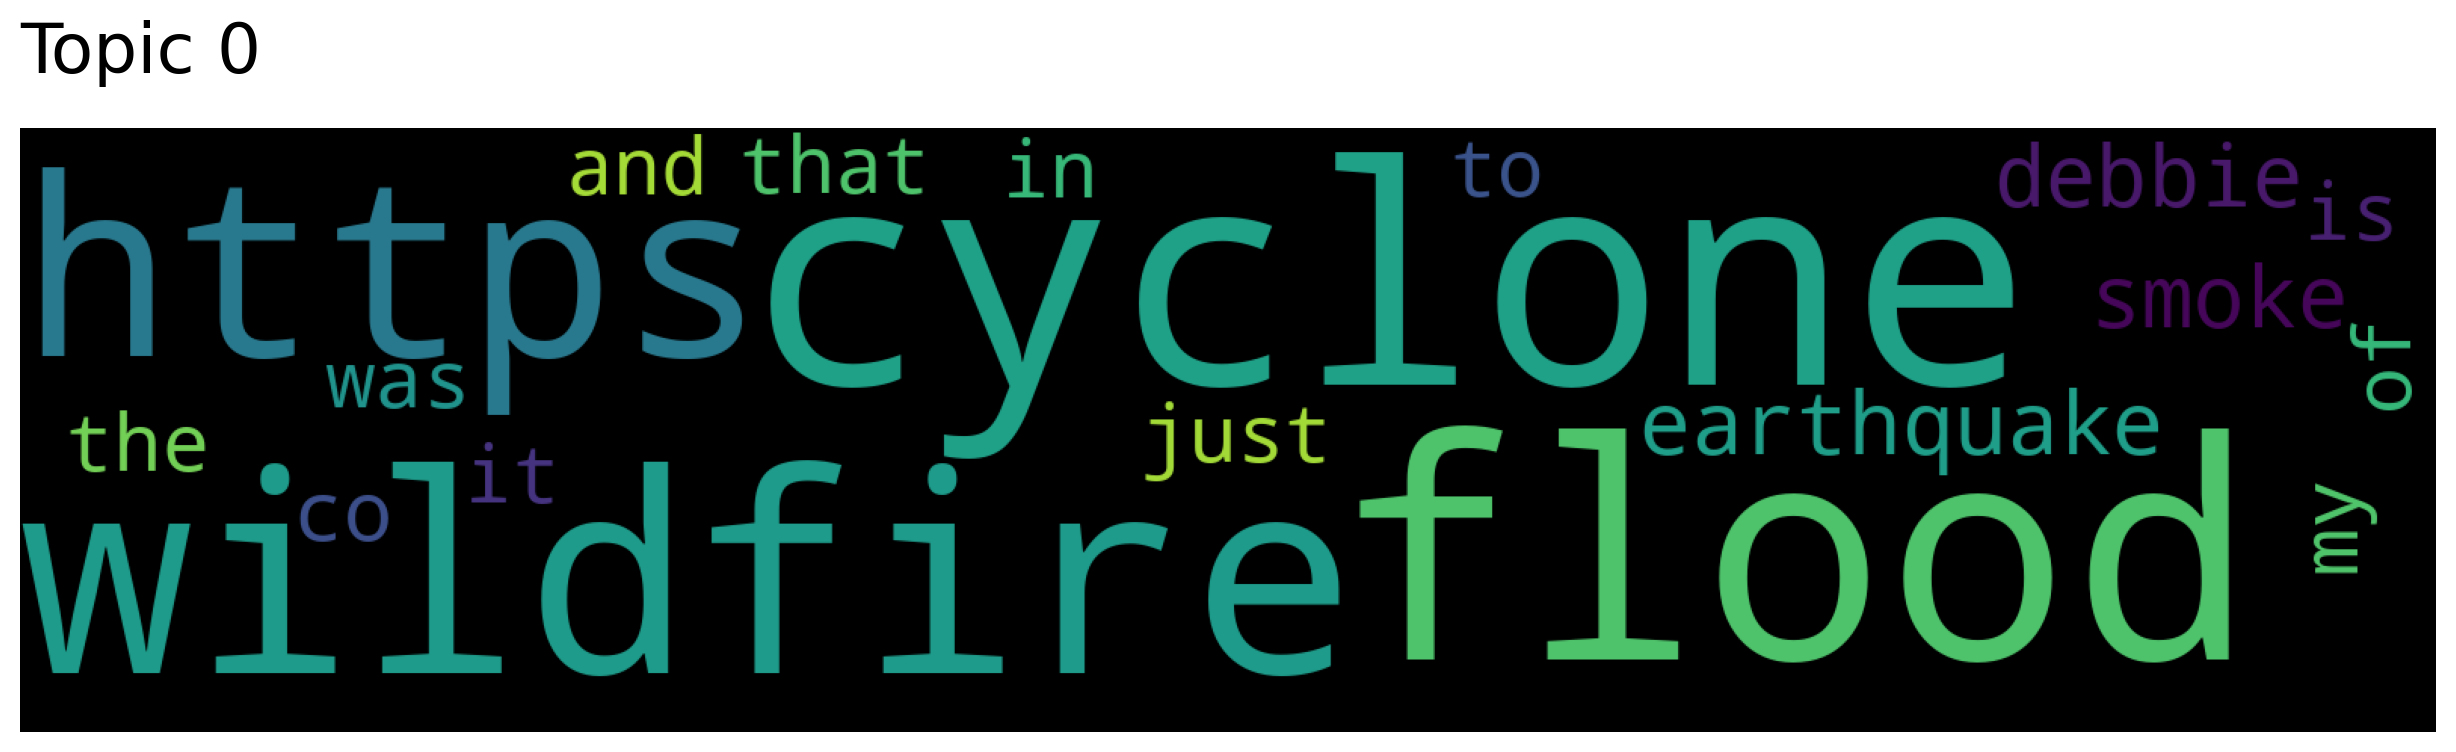

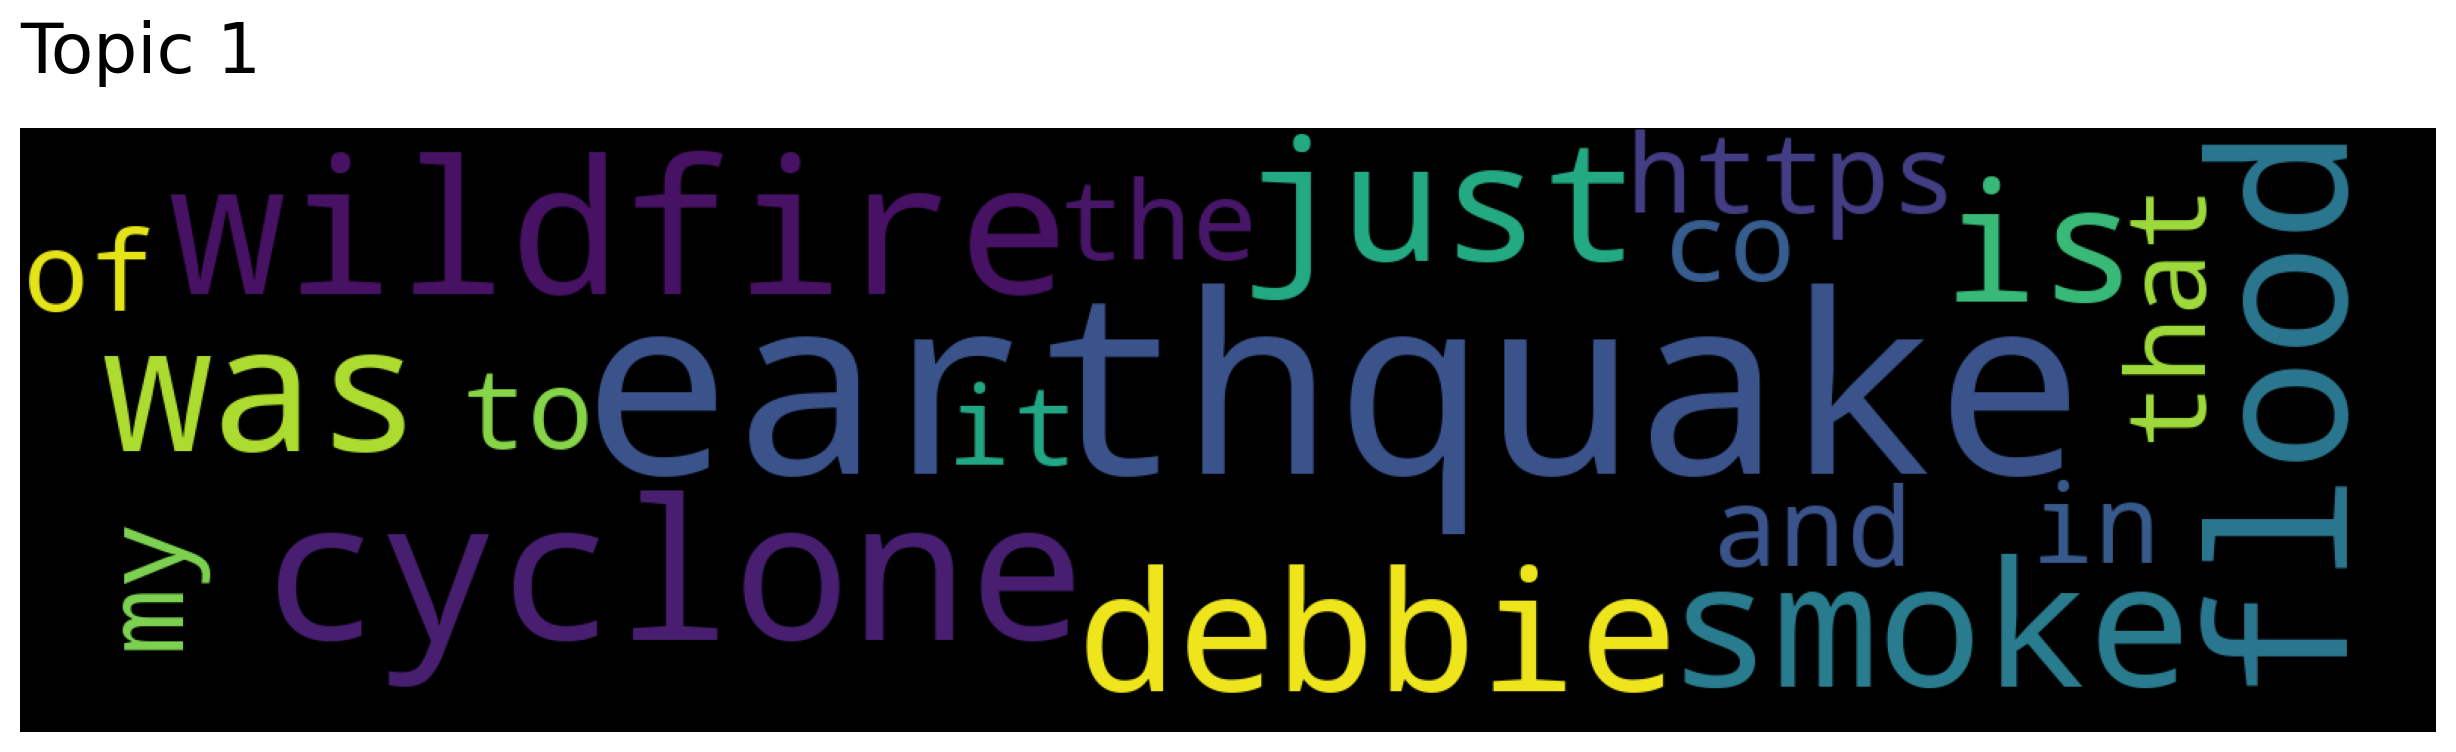

In [41]:
for topic_stat in topic_stats:
    model.generate_topic_wordcloud(topic_stat['topic_num'])

In [ ]:
model_output_df.to_json('asd.json',orient='records')

## Evaluation Part (Draft)

In [45]:
model_output = {"topics":[topic_stat['topic_words'] for topic_stat in topic_stats]}

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
for topk_val in range(1,30):
    metric_diversity = TopicDiversity(topk=topk_val)
    metric_coherence = Coherence(texts = [d.split(" ") for d in documents], topk = topk_val, measure = "c_v")
    score_diversity = metric_diversity.score(model_output)
    score_coherence = metric_coherence.score(model_output)
    print(f'> topk={topk_val},score_diversity={"%.2f" % score_diversity},score_coherence={"%.2f" %score_coherence}')

> topk=1,score_diversity=1.00,score_coherence=1.00
> topk=2,score_diversity=0.75,score_coherence=0.33
> topk=3,score_diversity=0.67,score_coherence=0.26
> topk=4,score_diversity=0.62,score_coherence=0.40
> topk=5,score_diversity=0.60,score_coherence=0.40
> topk=6,score_diversity=0.58,score_coherence=0.40
> topk=7,score_diversity=0.57,score_coherence=0.40
> topk=8,score_diversity=0.62,score_coherence=0.40
> topk=9,score_diversity=0.61,score_coherence=0.40
> topk=10,score_diversity=0.55,score_coherence=0.40
> topk=11,score_diversity=0.55,score_coherence=0.40
> topk=12,score_diversity=0.54,score_coherence=0.40
> topk=13,score_diversity=0.54,score_coherence=0.40
> topk=14,score_diversity=0.54,score_coherence=0.40
> topk=15,score_diversity=0.53,score_coherence=0.40
> topk=16,score_diversity=0.56,score_coherence=0.40
> topk=17,score_diversity=0.56,score_coherence=0.40
> topk=18,score_diversity=0.53,score_coherence=0.40
> topk=19,score_diversity=0.50,score_coherence=0.40


Exception: Words in topics are less than 20